# Отток клиентов

Из «N-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

   * Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.
   * Постройте модель с предельно большим значением *F1*-меры.
   * Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import phik
from phik.report import plot_correlation_matrix
from phik import report
from sklearn.utils import shuffle

from fast_ml.model_development import train_valid_test_split
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

## Подготовка данных

In [2]:
df = pd.read_csv("C:/Users/Vayradyan/Downloads/Churn.csv"); df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
df.columns = df.columns.str.lower(); df.head(5)

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
df.duplicated().sum()

0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  int64  
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  int64  
 7   tenure           9091 non-null   float64
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  int64  
 10  hascrcard        10000 non-null  int64  
 11  isactivemember   10000 non-null  int64  
 12  estimatedsalary  10000 non-null  float64
 13  exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [6]:
df.isna().sum()

rownumber            0
customerid           0
surname              0
creditscore          0
geography            0
gender               0
age                  0
tenure             909
balance              0
numofproducts        0
hascrcard            0
isactivemember       0
estimatedsalary      0
exited               0
dtype: int64

In [7]:
df['tenure'] = df['tenure'].fillna(df['tenure'].median()); df.isna().sum()

rownumber          0
customerid         0
surname            0
creditscore        0
geography          0
gender             0
age                0
tenure             0
balance            0
numofproducts      0
hascrcard          0
isactivemember     0
estimatedsalary    0
exited             0
dtype: int64

**Вывод:** 

   * загрузили данные
   * проверили на дубликаты - их нет
   * проверили на пропуски, они были в столбце "сколько лет человек являеться клиентом банка" - заменили их на 0

## Исследование задачи

* сделаем кодирование признаков стран и пола
* разобьем датасет на выборки
* постороим матрицу корреляций наших признаков, посмотрим что с чем и как связано

In [8]:
df = df.drop(['rownumber', 'surname', 'customerid'], axis=1)
df_ohe = pd.get_dummies(df, drop_first=True)
features = df_ohe.drop(['exited'], axis=1)
target = df_ohe['exited']

features_train, target_train, features_valid, target_valid, features_test, target_test = train_valid_test_split(df_ohe, target = 'exited', random_state=42,
                                                                            train_size=0.6, valid_size=0.2, test_size=0.2)

In [9]:
numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])

features_valid[numeric] = scaler.transform(features_valid[numeric])

features_test[numeric] = scaler.transform(features_test[numeric])

In [10]:
phik_overview = df_ohe.phik_matrix(interval_cols=df_ohe)

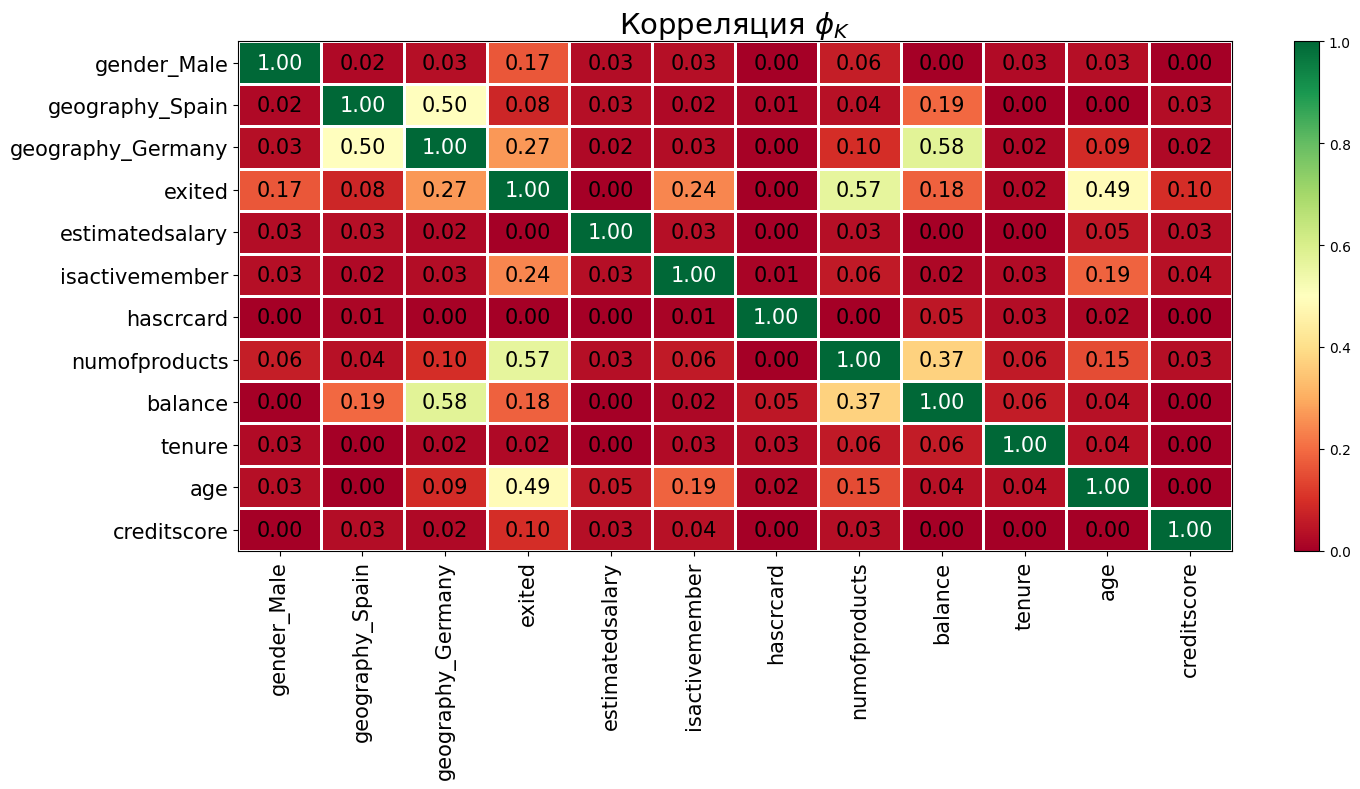

In [11]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, 
                        title=r"Корреляция $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(15, 8))
plt.tight_layout()

**Вывод:** довольно не плохие связи у признаков age - exited, balanced - Germany, numofproduct - exited

Проверим на баланс наш целевой признак

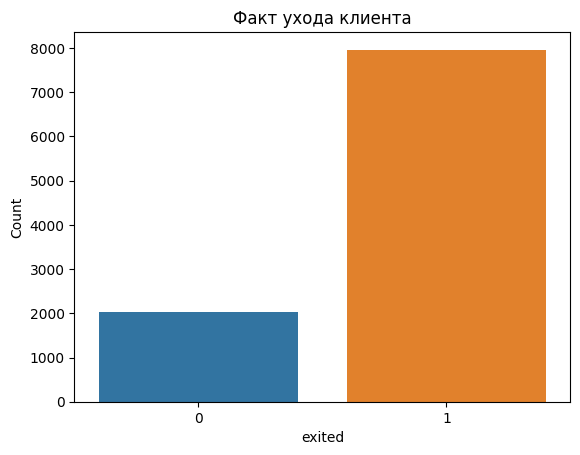

In [12]:
ax = sns.countplot(data = target, x=df['exited'])
ax.set(title = 'Факт ухода клиента', ylabel='Count')
plt.show();

**Вывод:** мы имеем дело с сильним дисбалансом, посмотрим что покажет с ним и без него наша F1 и какой будет AUC-ROC

In [13]:
best_model = None
best_auc_roc = 0

for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=42, max_depth=depth, criterion='gini')
    model.fit(features_train, target_train)
    pred_valid = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    if auc_roc > best_auc_roc:
        best_model = model
        best_auc_roc = auc_roc
        
print('F1-score:', f1_score(target_valid, pred_valid))
print('AUC-ROC:', best_auc_roc)
print('Best model:', best_model)

F1-score: 0.5135951661631419
AUC-ROC: 0.8021994801819363
Best model: DecisionTreeClassifier(max_depth=7, random_state=42)


In [14]:
best_model = None
best_auc_roc = 0

for depth in range(1, 12):
    for est in range(100, 130):
        model = RandomForestClassifier(max_depth = depth, n_estimators=est, random_state=42)
        model.fit(features_train, target_train)
        pred_valid = model.predict(features_valid)
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
        if auc_roc > best_auc_roc:
            best_model = model
            best_auc_roc = auc_roc
            
print('F1-score:', f1_score(target_valid, pred_valid))
print('AUC-ROC:', best_auc_roc)
print('Best model:', best_model)

F1-score: 0.5380710659898478
AUC-ROC: 0.8485071474983755
Best model: RandomForestClassifier(max_depth=9, n_estimators=118, random_state=42)


In [15]:
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(features_train, target_train)
pred_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('F1-score:', f1_score(target_valid, pred_valid))
print('AUC-ROC:', auc_roc)

F1-score: 0.29615384615384616
AUC-ROC: 0.7519753086419753


**Вывод:** как и ожидалось весьма скудный результат для F1

## Борьба с дисбалансом

* попробуем увеличить выборку в 4 раза так как у нас соотношение 1:4

In [16]:
def upsample(features, target, repeat):
    features_zeros = features[target==0]
    features_ones = features[target==1]
    target_zeros = target[target==0]
    target_ones = target[target==1]
    
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=42)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(features_upsampled.shape)
print(target_upsampled.shape)

(9681, 11)
(9681,)


In [17]:
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
pred_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('F1-score:', f1_score(target_valid, pred_valid))
print('AUC-ROC:', auc_roc)

F1-score: 0.46379310344827585
AUC-ROC: 0.7528135152696555


In [18]:
best_model = None
best_auc_roc = 0

for depth in range(1, 20):
    for est in range(100, 130):
        model = RandomForestClassifier(max_depth = depth, n_estimators=est, random_state=42)
        model.fit(features_upsampled, target_upsampled)
        pred_valid = model.predict(features_valid)
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
        if auc_roc > best_auc_roc:
            best_model = model
            best_auc_roc = auc_roc
            
print('F1-score:', f1_score(target_valid, pred_valid))
print('AUC-ROC:', best_auc_roc)
print('Best model:', best_model)

F1-score: 0.5682758620689656
AUC-ROC: 0.8433950617283953
Best model: RandomForestClassifier(max_depth=8, n_estimators=111, random_state=42)


In [19]:
best_model = None
best_auc_roc = 0

for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=42, max_depth=depth, criterion='gini')
    model.fit(features_upsampled, target_upsampled)
    pred_valid = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    if auc_roc > best_auc_roc:
        best_model = model
        best_auc_roc = auc_roc
        
print('F1-score:', f1_score(target_valid, pred_valid))
print('AUC-ROC:', best_auc_roc)
print('Best model:', best_model)

F1-score: 0.5163398692810458
AUC-ROC: 0.808514457439896
Best model: DecisionTreeClassifier(max_depth=6, random_state=42)


* попробуем теперь ее уменьшить так же на четверть

In [20]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=42)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=42)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=42)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [21]:
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
pred_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('F1-score:', f1_score(target_valid, pred_valid))
print('AUC-ROC:', auc_roc)

F1-score: 0.46101113967437873
AUC-ROC: 0.7504515919428202


In [22]:
best_model = None
best_auc_roc = 0

for depth in range(1, 12):
    for est in range(100, 130):
        model = RandomForestClassifier(max_depth = depth, n_estimators=est, random_state=42)
        model.fit(features_downsampled, target_downsampled)
        pred_valid = model.predict(features_valid)
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
        if auc_roc > best_auc_roc:
            best_model = model
            best_auc_roc = auc_roc
            
print('F1-score:', f1_score(target_valid, pred_valid))
print('AUC-ROC:', best_auc_roc)
print('Best model:', best_model)

F1-score: 0.5304937076476283
AUC-ROC: 0.8398554256010395
Best model: RandomForestClassifier(max_depth=6, n_estimators=106, random_state=42)


In [23]:
best_model = None
best_auc_roc = 0

for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=42, max_depth=depth, criterion='gini')
    model.fit(features_downsampled, target_downsampled)
    pred_valid = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    if auc_roc > best_auc_roc:
        best_model = model
        best_auc_roc = auc_roc
        
print('F1-score:', f1_score(target_valid, pred_valid))
print('AUC-ROC:', best_auc_roc)
print('Best model:', best_model)

F1-score: 0.48686868686868684
AUC-ROC: 0.811169590643275
Best model: DecisionTreeClassifier(max_depth=5, random_state=42)


## Тестирование модели

In [24]:
model = RandomForestClassifier(max_depth = 8, n_estimators=111, random_state=42)
model.fit(features_upsampled, target_upsampled)
pred_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
            
print('F1-score:', f1_score(target_test, pred_test))
print('AUC-ROC:', auc_roc)

F1-score: 0.6377097729516288
AUC-ROC: 0.8664864464523775


**Вывод:**  В ходе работы мы сталкнулсь с сильным дисбаланосом класса. Увеличив выборку искусственно мы стабилизировали и избавились от дисбаланса в нашем целевом признаке, что дало нам весьма не плохой результат на F1 мере, что в свою очередь дало нам не плохо предсказание на нашей модели в вопросе о том уйдет клиет или нет в ближайшее время из банка.